#  Encoding a MOF for deep dreaming

In [1]:
# imports
import sys, os
sys.path.append('../deep_dream_src/')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
from plot_utils import draw_smiles_linker, create_parity_plot
from nn_functions import featurize_df, prepare_hybrid_dataset, MolecularLSTMModel, prepare_dreaming_mof, prepare_dreaming_edge, split_dataframe
from utils import *
from tokenizer_functions import *
import selfies as sf
from group_selfies import GroupGrammar, bond_constraints
import math
import pickle 
group_constraints = {'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2, 'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4, 'N-1': 2, 'C': 4, 'C+1': 3, 'C-1': 3, 'P': 5, 'P+1': 6, 'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8, '*': math.inf, 'Fr': 1}
bond_constraints.set_semantic_constraints(group_constraints)
from dreaming_functions import *
import rdkit
from rdkit import Chem
rdkit.RDLogger.DisableLog('rdApp.warning')

c:\Users\x82753cc\AppData\Local\anaconda3\envs\TESTING_DREAMING_TEST\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part 1: Required input representation

The training data we use to for our deep dreaming is in the following form:

In [7]:
training_data = pd.read_csv('../train_models/training_data.csv')
training_data.head(1)

,edge_selfie,edge_canon_smile,edge_group_selfie,group_selfie_length,node_selfie,topo,SA_score,connection_point,MOFname,totalPOV_VF,...,GSA,henry_coefficient_CO2_300_mol_kg_Pa,log_henry_coefficient_CO2_300,heat_of_adsorption_CO2_300_kJ_mol,henry_coefficient_N2_300_mol_kg_Pa,log_henry_coefficient_N2_300,heat_of_adsorption_N2_300_kJ_mol,henry_CO2_N2_selectivity,log_CO2_N2_selectivity,filename
0,[O][O][C][=C][C][Branch1][C][Fr][C][Branch1][R...,OOC1=CC([Fr])C(OO)=CC1=C1NN([Fr])N1,[O][O][C][=C][C][Branch][C][=Branch][=C][C][Br...,28,[Fr][C][O][Cu][O][C][Branch1][C][Fr][O][Cu][Br...,acs,5.938156,"[11, 27]",acs_N125_edge1276,0.7545,...,4100.11,0.000005,-12.2,-10.097733,0.000002,-13.3,-4.43999,2.92,1.072161,acs_N125_edge1276.cif


The columns you need are: 
* edge representation (group SELFIES)
* node representation (SELFIES)
* topology represention (RSCR topology code)
* target (property)

We tokenize the [edge, node+topo] string representations using the following functionalities (using $c_p$ as the property case study):

In [10]:
target_names = ['cp']

mof_selfies_encoding, tokenized_info = featurize_df(
    training_data,
    target_names,
    edge_rep = 'edge_group_selfie',
    node_rep = 'node_selfie',
    topo_rep = 'topo'
    )


../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [11]:
mof_selfies_encoding.head(1)

,MOFname,edge_group_selfie,node_selfie,topo,cp,tokenized_edge_selfies,edge_lens,node_plus_topo,tokenized_node_plus_topo,node_plus_topo_lens,mof_string,tokenized_mof_string,mof_string_lens
0,acs_N125_edge1276,[O][O][C][=C][C][Branch][C][=Branch][=C][C][Br...,[Fr][C][O][Cu][O][C][Branch1][C][Fr][O][Cu][Br...,acs,0.857962,"[66, 66, 61, 52, 61, 60, 61, 51, 52, 61, 60, 6...",28,[Fr][C][O][Cu][O][C][Branch1][C][Fr][O][Cu][Br...,"[34, 22, 48, 28, 48, 22, 20, 22, 34, 48, 28, 2...",55,[O][O][C][=C][C][Branch][C][=Branch][=C][C][Br...,"[104, 104, 75, 58, 75, 74, 75, 57, 58, 75, 74,...",85


In [17]:
print(tokenized_info.keys())

dict_keys(['max_len_selfie', 'alphabet', 'symbol_to_idx', 'node_plus_topo_max_len_selfie', 'node_plus_topo_alphabet', 'node_plus_topo_symbol_to_idx', 'mof_string_max_len_selfie', 'mof_string_alphabet', 'mof_string_symbol_to_idx'])


We then process this information for machine learning purposes using the following code

In [ ]:
samples = 10000
split_by = {
    'method': 'sample',
    'train': samples,
    'validate': 1000,
    'test': 1000
    }

train_df, validate_df, test_df = split_dataframe(mof_selfies_encoding, split_by, seed=42)


In [9]:
train_df.head(1)

,MOFname,edge_group_selfie,node_selfie,topo,cp,tokenized_edge_selfies,edge_lens,node_plus_topo,tokenized_node_plus_topo,node_plus_topo_lens,mof_string,tokenized_mof_string,mof_string_lens
0,sxb_N265_edge4527,[:0methyl_amine][Ring1][C][=C][Branch][C][Bran...,[Fr][C][O][Zn][O][C][Branch1][C][Fr][O][Zn][Br...,sxb,0.939584,"[16, 68, 61, 52, 60, 61, 60, 65, 52, 60, 64, 7...",31,[Fr][C][O][Zn][O][C][Branch1][C][Fr][O][Zn][Br...,"[34, 22, 48, 65, 48, 22, 20, 22, 34, 48, 65, 2...",56,[:0methyl_amine][Ring1][C][=C][Branch][C][Bran...,"[20, 110, 75, 58, 74, 75, 74, 101, 58, 74, 89,...",89


Which we can then pass to our model for making predictions by loading in the pretrained models:

In [14]:
predictor_name = f'LSTM_interval_noise_00_{target_names[0]}_11000samples_group_selfies'
with open('../train_models/mof_saved_models/{}.pkl'.format(predictor_name), 'rb') as f:
    predictor_train_info = pickle.load(f)
predictor_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple

predictor_hyperparams = predictor_train_info['hyperparams']
predictor_scaler = predictor_train_info['scaler']

predictor_model = MolecularLSTMModel(**predictor_hyperparams)
predictor_model.load_state_dict(predictor_train_info['model_state_dict'])

<All keys matched successfully>

And then preparing the dataset for ML applications

(1000, 1)


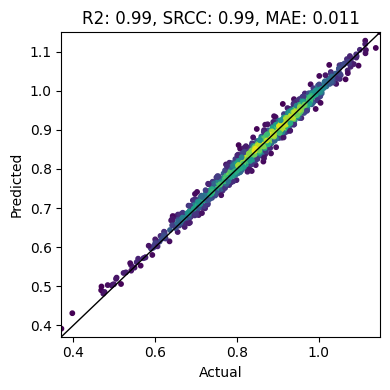

In [18]:
test_loader, _ = prepare_hybrid_dataset(
    test_df,
    tokenized_info,
    target_names,
    pad_node=False,
    batch_size=1,
    shuffle=True,
    train=False,
    scaler=predictor_scaler,
    noise_level=predictor_train_info['noise_level']
)
create_parity_plot(predictor_model, predictor_scaler, test_loader)

# Part 2: Preparing MOFs for featurisation

We need to get our MOFs into the form of our training data, i.e., we need an
* edge representation (group SELFIES)
* node representation (SELFIES)
* topology represention (RSCR topology code)

For this, let us make use of pormake, which has MOF building blocks pre-loaded in its database methods. For example, we can extract a building block like so:

In [23]:
import pormake as pm
db = pm.Database()
print(db.building_block_list)

['E1', 'E10', 'E101', 'E102', 'E103', 'E104', 'E105', 'E106', 'E107', 'E108', 'E109', 'E11', 'E110', 'E111', 'E112', 'E113', 'E114', 'E115', 'E116', 'E118', 'E119', 'E12', 'E120', 'E121', 'E122', 'E123', 'E125', 'E126', 'E127', 'E128', 'E129', 'E13', 'E130', 'E131', 'E132', 'E133', 'E134', 'E135', 'E136', 'E137', 'E138', 'E139', 'E14', 'E141', 'E142', 'E143', 'E145', 'E146', 'E147', 'E148', 'E149', 'E15', 'E150', 'E151', 'E152', 'E153', 'E154', 'E155', 'E156', 'E157', 'E158', 'E159', 'E16', 'E160', 'E161', 'E162', 'E163', 'E165', 'E166', 'E167', 'E168', 'E169', 'E17', 'E170', 'E171', 'E172', 'E173', 'E174', 'E175', 'E176', 'E177', 'E178', 'E179', 'E18', 'E180', 'E181', 'E182', 'E183', 'E184', 'E185', 'E186', 'E187', 'E188', 'E189', 'E19', 'E190', 'E191', 'E192', 'E193', 'E194', 'E195', 'E196', 'E197', 'E198', 'E199', 'E2', 'E20', 'E201', 'E202', 'E203', 'E204', 'E205', 'E206', 'E207', 'E208', 'E209', 'E21', 'E210', 'E211', 'E212', 'E213', 'E215', 'E216', 'E217', 'E218', 'E219', 'E22', 

In [ ]:
edge_BBs = [bb for bb in db.building_block_list if 'E' in bb]
node_BBs = list(set([x.split('_')[1] for x in training_data['filename']])) # or [bb for bb in db.building_block_list if 'N' in bb] if you want to look at all nodes, not just those in training data

In [43]:
db.get_bb(edge_BBs[0]).view()
db.get_bb(node_BBs[0]).view()

So, we have a list of building blocks which we can create `BuildingBlock` objects from using the pormake database. Now, let us extract the smiles strings of these building blocks and then prepare them into the correct string notations for deep dreaming. We will show this for a single MOF. First, lets get the smiles strings

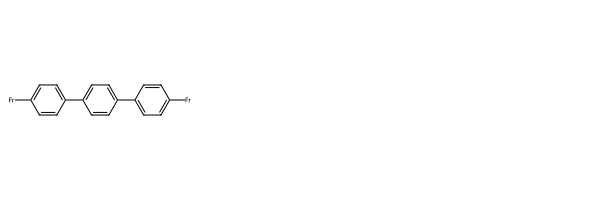

In [ ]:
from sbu_functions import get_smiles_for_bb

edge_smi = get_smiles_for_bb(db.get_bb(edge_BBs[0]))
draw_smiles_linker([edge_smi.replace('X','Fr')]) # replace connection point with Fr

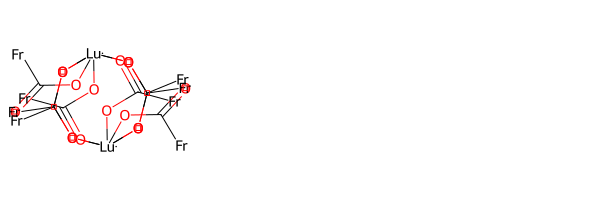

In [44]:
node_smi = get_smiles_for_bb(db.get_bb(node_BBs[0]))
draw_smiles_linker([node_smi.replace('X','Fr')]) # replace connection point with Fr

Next, lets convert them to the appropriate string notations (Group SELFIES for edges, SELFIES for nodes)

In [ ]:
group_grammar = GroupGrammar.from_file('./gs_mof_grammar.txt')
mol = Chem.MolFromSmiles(edge_smi.replace('X','Fr'))
edge_rep = group_grammar.full_encoder(mol)   # encode mol object using Group SELFIES tokens stored in group_grammar
print(f'smi: {edge_smi.replace("X","Fr")}\nML representation: {edge_rep}')

smi: [Fr]C1=CC=C(C2=CC=C(C3=CC=C([Fr])C=C3)C=C2)C=C1
gs: [FrH0][:0benzene][Branch][:0benzene][Branch][:0benzene][Branch][FrH0][pop][pop][pop]


In [61]:
node_rep = sf.encoder(node_smi.replace('X','Fr'))
print(f'smi: {node_smi.replace("X","Fr")}\nML representation: {node_rep}')

smi: O=C([Fr])O[Lu]123(OC([Fr])=O)OC([Fr])O[Lu](OC([Fr])=O)(OC([Fr])O3)(OC([Fr])O2)(OC([Fr])O1)OC([Fr])=O
ML representation: [O][=C][Branch1][C][Fr][O][Lu][Branch1][#Branch1][O][C][Branch1][C][Fr][=O][O][C][Branch1][C][Fr][O][Lu][Branch1][#Branch1][O][C][Branch1][C][Fr][=O][Branch1][#Branch2][O][C][Branch1][C][Fr][O][Ring2][Ring1][C][Branch1][#Branch2][O][C][Branch1][C][Fr][O][Ring2][Ring1][=Branch1][Branch1][#Branch2][O][C][Branch1][C][Fr][O][Ring2][Ring1][#Branch2][O][C][Branch1][C][Fr][=O]


Let's pair these BBs with the `dmp` topology and construct it to see if these BBs are compatible

In [ ]:
from sbu_functions import construct_mof

construct_mof(
    topology='dmp',
    node=node_BBs[0],
    edge_smi = edge_smi.replace('X','Fr'),
    edge_smi_name = f'{edge_smi.replace("X","Fr")}',
    save_mof_to_dir = './',
    cif_file_name="example_CIF.cif"
    )

>>> == Min RMSD of (node type: 0, node bb: N337): 2.47E-01
>>> Pre-location at node slot 0, (node type: 0, node bb: N337), RMSD: 2.90E-01
>>> RMSD > MIN_RMSD*1.01, relocate Node 0 with 216 trial orientations, RMSD: 2.47E-01
>>> Pre-location at node slot 1, (node type: 0, node bb: N337), RMSD: 3.36E-01
>>> RMSD > MIN_RMSD*1.01, relocate Node 1 with 216 trial orientations, RMSD: 2.51E-01
>>> RMSD > MIN_RMSD*1.01, relocate Node 1 with 216 trial orientations and chiral building block, RMSD: 2.47E-01
>>> Pre-location at node slot 2, (node type: 0, node bb: N337), RMSD: 2.90E-01
>>> RMSD > MIN_RMSD*1.01, relocate Node 2 with 216 trial orientations, RMSD: 2.47E-01
>>> Pre-location at node slot 3, (node type: 0, node bb: N337), RMSD: 3.36E-01
>>> RMSD > MIN_RMSD*1.01, relocate Node 3 with 216 trial orientations, RMSD: 2.51E-01
>>> RMSD > MIN_RMSD*1.01, relocate Node 3 with 216 trial orientations and chiral building block, RMSD: 2.47E-01
>>> Topology optimization starts.


./bbs\[Fr]C1=CC=C(C2=CC=C(C3=CC=C([Fr])C=C3)C=C2)C=C1.xyz
RMSD at random node type 0: 0.25


>>> MESSAGE: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
>>> SUCCESS: True
>>> ITER: 29
>>> OBJ: 0.099
>>> Location at node slot 0, (node type: 0, node bb: N337), RMSD: 1.87E-01
>>> Location at node slot 1, (node type: 0, node bb: N337), RMSD: 1.87E-01
>>> Location at node slot 2, (node type: 0, node bb: N337), RMSD: 1.87E-01
>>> Location at node slot 3, (node type: 0, node bb: N337), RMSD: 1.87E-01
>>> Start placing edges.
c:\Users\x82753cc\AppData\Local\anaconda3\envs\deep_dreaming\lib\site-packages\pormake\locator.py:20: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  U, rmsd = scipy.spatial.transform.Rotation.align_vectors(p, q)
>>> Start finding bonds in generated framework.
>>> Start finding bonds in building blocks.
>>> Start finding bonds between building blocks.
>>> Start making Framework instance.
>>> Construction of framework done.
c:\Users\x82753cc\AppData\Local\anaconda3\envs\deep_dreaming\lib\site-packages\ase\utils\__i

example_CIF.cif


c:\Users\x82753cc\AppData\Local\anaconda3\envs\deep_dreaming\lib\site-packages\ase\io\cif.py:401: UserWarning: crystal system 'triclinic' is not interpreted for space group Spacegroup(1, setting=1). This may result in wrong setting!
  warnings.warn(


<Axes: >

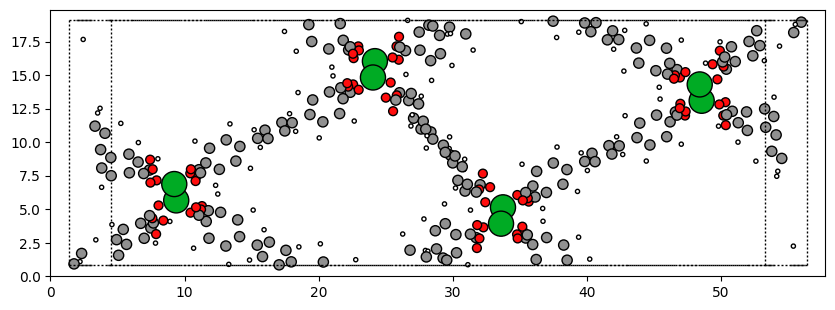

In [90]:
from ase.io import read
from ase.visualize.plot import plot_atoms

example_cif = read('./example_CIF.cif')
fig,ax=plt.subplots(1,1,figsize=(10,10))
plot_atoms(example_cif, ax, radii=0.5, rotation=('0x,0y,0z'))

The associated string representations for this MOF would then be:

In [92]:
pd.DataFrame({
    'edge_group_selfie': edge_rep,
    'node_selfie': node_rep,
    'topo': 'dmp'},
    index=[0],
)

,edge_group_selfie,node_selfie,topo
0,[FrH0][:0benzene][Branch][:0benzene][Branch][:...,[O][=C][Branch1][C][Fr][O][Lu][Branch1][#Branc...,dmp


Which we can use to pass into the `featurize_df` function, provided there is an additional column(s) for the target (property) values. From there, follow the steps provided at the start of this jupyter notebook or follow the `../train_models/train_model.ipynb` to train a new model on new MOFs constructed from pormake.